In [73]:
import numpy as np
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *
import torch
dry_run = False

In [74]:
print(torch.cuda.is_available())

True


In [58]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='moons')

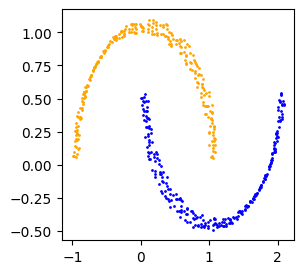

In [59]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

In [60]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())
print(torch.version.cuda)


X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

cuda:0
True
11.6


In [61]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [62]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)                       
    )
t_span = torch.linspace(0, 1, 5)
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [63]:
t_span = torch.linspace(0,1,100)
t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()

In [64]:
print(model)

Neural ODE:
	- order: 1        
	- solver: DormandPrince45()
	- adjoint solver: DormandPrince45()        
	- tolerances: relative 0.001 absolute 0.001        
	- adjoint tolerances: relative 0.0001 absolute 0.0001        
	- num_parameters: 82        
	- NFE: 596.0


In [65]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)                       
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

learn = Learner(t_span, model)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=1, max_epochs=2)  # 200, 300 default
trainer.fit(learn)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\kevin\Desktop\GitHub\neural_dynamics_learning\venv\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 82    
------------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


c:\Users\kevin\Desktop\GitHub\neural_dynamics_learning\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\kevin\Desktop\GitHub\neural_dynamics_learning\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1555: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Text(0.5, 1.0, 'Dimension 1')

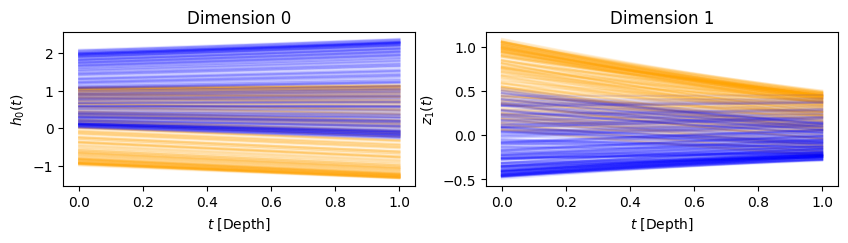

In [68]:
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(500):
    ax0.plot(t_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(t_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")

In [72]:
model.to("cpu")

X_test, yn_test = d.generate(n_samples=512, noise=3e-1, dataset_type='moons')

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])



(tensor([0., 1.], grad_fn=<_ODEProblemFuncBackward>),
 tensor([[[1.0496, 0.0496],
          [1.0872, 0.0996],
          [1.0381, 0.0630],
          ...,
          [2.0486, 0.5243],
          [2.0478, 0.5356],
          [2.0423, 0.5423]],
 
         [[0.5834, 0.0670],
          [0.6218, 0.1144],
          [0.5750, 0.0771],
          ...,
          [1.5384, 0.6045],
          [1.5382, 0.6149],
          [1.5333, 0.6204]]], grad_fn=<_ODEProblemFuncBackward>))